#Imports

In [ ]:
import urllib.request
import os
import numpy as np
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import re, string
import nltk
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from tabulate import tabulate

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
table=[]
table_lemm=[]
table_menthash=[]

#Read dataset

In [ ]:
df_test = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

#Classification (cleaned_text)

##Preprocessing

In [ ]:
X_train = df_train['cleaned_text']
y_train = df_train[['irony','sarcasm']].values

In [ ]:
X_test = df_test['cleaned_text']
y_test = df_test[['irony','sarcasm']].values

Encoding of target variables

In [ ]:
y_train= y_train.sum(axis=1)
y_test= y_test.sum(axis=1)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


##Multiclass Classification

###SVC

In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
clf= SVC(C=1, gamma='scale', kernel='rbf', random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.70      0.89      0.78      1954
       Irony       0.66      0.51      0.57      1110
     Sarcasm       0.74      0.52      0.61       913

    accuracy                           0.70      3977
   macro avg       0.70      0.64      0.66      3977
weighted avg       0.70      0.70      0.68      3977



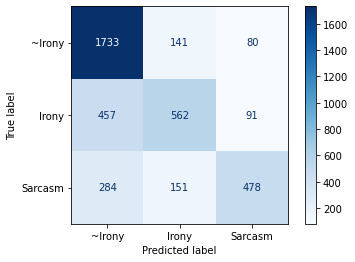

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.63      0.69      0.66       437
       Irony       0.35      0.39      0.37       219
     Sarcasm       0.39      0.28      0.33       216

    accuracy                           0.51       872
   macro avg       0.46      0.45      0.45       872
weighted avg       0.50      0.51      0.50       872



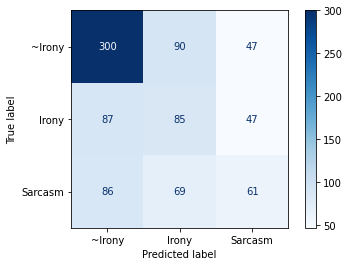

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'SVM':d})

###Naive Bayes

####Multinomial

In [ ]:
param_grid={
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.001}

In [ ]:
clf= MultinomialNB(alpha=0.001)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.63      0.89      0.74      1954
       Irony       0.63      0.33      0.43      1110
     Sarcasm       0.63      0.44      0.52       913

    accuracy                           0.63      3977
   macro avg       0.63      0.55      0.56      3977
weighted avg       0.63      0.63      0.60      3977



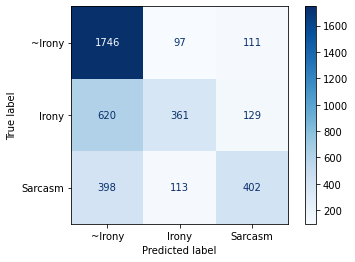

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.56      0.80      0.66       437
       Irony       0.42      0.19      0.26       219
     Sarcasm       0.38      0.27      0.32       216

    accuracy                           0.51       872
   macro avg       0.46      0.42      0.41       872
weighted avg       0.48      0.51      0.47       872



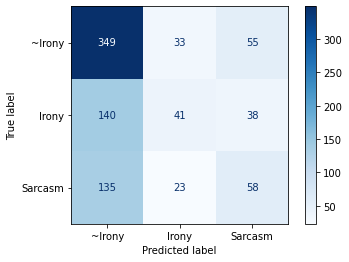

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'Multinomial NB':d})

####Complement

In [ ]:
param_grid={
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'norm': [True, False]
}

In [ ]:
grid= GridSearchCV(ComplementNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=ComplementNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'norm': [True, False]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 1, 'norm': False}

In [ ]:
clf= ComplementNB(alpha=1, norm=False)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.66      0.79      0.72      1954
       Irony       0.60      0.34      0.43      1110
     Sarcasm       0.51      0.57      0.54       913

    accuracy                           0.61      3977
   macro avg       0.59      0.56      0.56      3977
weighted avg       0.61      0.61      0.60      3977



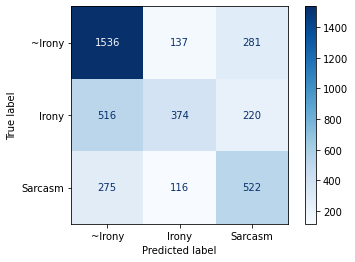

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.60      0.70      0.65       437
       Irony       0.44      0.17      0.25       219
     Sarcasm       0.34      0.43      0.38       216

    accuracy                           0.50       872
   macro avg       0.46      0.43      0.42       872
weighted avg       0.49      0.50      0.48       872



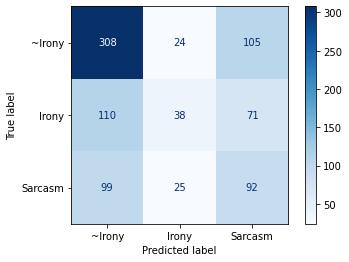

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'Complement NB':d})

###DecisionTree

In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 45,
 'min_samples_leaf': 10,
 'min_samples_split': 40}

In [ ]:
clf= DecisionTreeClassifier(criterion='gini', max_depth=45, min_samples_leaf=10, min_samples_split=40)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.69      0.83      0.75      1954
       Irony       0.54      0.45      0.49      1110
     Sarcasm       0.56      0.43      0.49       913

    accuracy                           0.63      3977
   macro avg       0.60      0.57      0.58      3977
weighted avg       0.62      0.63      0.62      3977



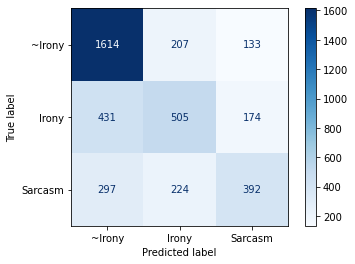

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.63      0.66      0.65       437
       Irony       0.35      0.43      0.39       219
     Sarcasm       0.39      0.26      0.31       216

    accuracy                           0.50       872
   macro avg       0.46      0.45      0.45       872
weighted avg       0.50      0.50      0.50       872



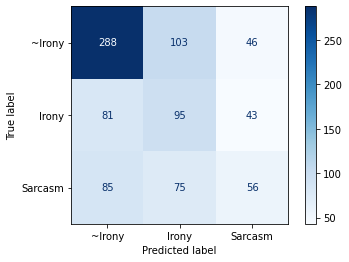

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table.append({'DT':d})

#Classification (lemmatized_text)

##Preprocessing

In [ ]:
X_train = df_train['lemmatized_text']
y_train = df_train[['irony','sarcasm']].values

In [ ]:
X_test = df_test['cleaned_text']
y_test = df_test[['irony','sarcasm']].values

In [ ]:
y_train= y_train.sum(axis=1)
y_test= y_test.sum(axis=1)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


##Multiclass Classification

###SVC

In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
clf= SVC(C=1, gamma='scale', kernel='rbf', random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.72      0.89      0.80      1954
       Irony       0.68      0.55      0.61      1110
     Sarcasm       0.75      0.55      0.63       913

    accuracy                           0.72      3977
   macro avg       0.72      0.66      0.68      3977
weighted avg       0.72      0.72      0.71      3977



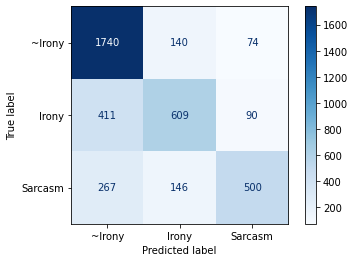

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.64      0.66      0.65       437
       Irony       0.36      0.48      0.41       219
     Sarcasm       0.39      0.23      0.29       216

    accuracy                           0.51       872
   macro avg       0.46      0.46      0.45       872
weighted avg       0.51      0.51      0.50       872



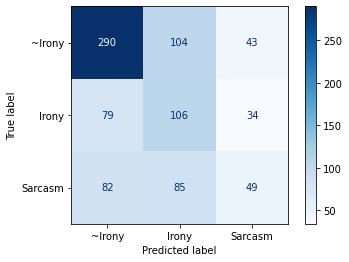

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lemm.append({'SVM':d})

###Naive Bayes

####Multinomial

In [ ]:
param_grid={
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.001}

In [ ]:
clf= MultinomialNB(alpha=0.001)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.63      0.90      0.74      1954
       Irony       0.65      0.32      0.43      1110
     Sarcasm       0.62      0.44      0.51       913

    accuracy                           0.63      3977
   macro avg       0.63      0.55      0.56      3977
weighted avg       0.63      0.63      0.60      3977



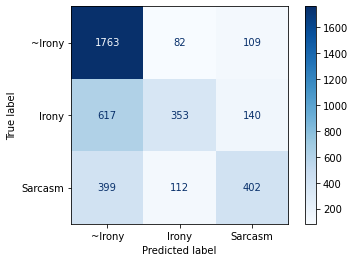

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.56      0.78      0.65       437
       Irony       0.39      0.19      0.26       219
     Sarcasm       0.35      0.25      0.29       216

    accuracy                           0.50       872
   macro avg       0.43      0.41      0.40       872
weighted avg       0.46      0.50      0.46       872



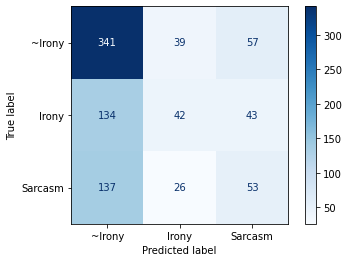

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lemm.append({'Multinomial NB':d})

####Complement

In [ ]:
param_grid={
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'norm': [True, False]
}

In [ ]:
grid= GridSearchCV(ComplementNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=ComplementNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'norm': [True, False]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 20,
 'min_samples_split': 5}

In [ ]:
clf= ComplementNB(alpha=0.1, norm=False)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.67      0.76      0.71      1954
       Irony       0.57      0.37      0.44      1110
     Sarcasm       0.50      0.57      0.53       913

    accuracy                           0.61      3977
   macro avg       0.58      0.57      0.56      3977
weighted avg       0.60      0.61      0.60      3977



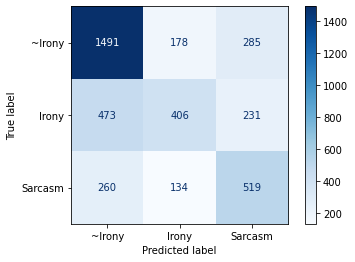

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.57      0.69      0.62       437
       Irony       0.39      0.14      0.20       219
     Sarcasm       0.34      0.42      0.37       216

    accuracy                           0.48       872
   macro avg       0.43      0.41      0.40       872
weighted avg       0.47      0.48      0.45       872



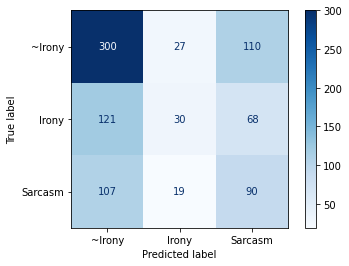

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lemm.append({'Complement NB':d})

###DecisionTree

In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 15,
 'min_samples_split': 60}

In [ ]:
clf= DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_leaf=25, min_samples_split=60, random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.67      0.82      0.74      1954
       Irony       0.51      0.50      0.50      1110
     Sarcasm       0.57      0.29      0.39       913

    accuracy                           0.61      3977
   macro avg       0.58      0.54      0.54      3977
weighted avg       0.60      0.61      0.59      3977



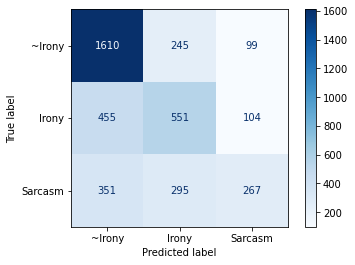

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.66      0.65      0.65       437
       Irony       0.32      0.51      0.40       219
     Sarcasm       0.35      0.16      0.22       216

    accuracy                           0.49       872
   macro avg       0.45      0.44      0.42       872
weighted avg       0.50      0.49      0.48       872



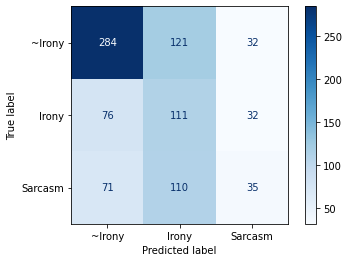

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_lemm.append({'DT':d})

#Classification (cleaned_text_mention_hashtag)

##Preprocessing

In [ ]:
X_train = df_train['cleaned_text_mention_hashtag']
y_train = df_train[['irony','sarcasm']].values

In [ ]:
X_test = df_test['cleaned_text_mention_hashtag']
y_test = df_test[['irony','sarcasm']].values

In [ ]:
y_train= y_train.sum(axis=1)
y_test= y_test.sum(axis=1)

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


##Multiclass Classification

###SVC

In [ ]:
param_grid=[{
    'C':[0.1, 1, 10, 100], 
    'kernel':[ 'linear']
    },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale','auto'], 
    'kernel':['rbf']
     },
    {'C':[0.1, 1, 10, 100],
    'gamma':['scale', 'auto'], 
    'kernel':[ 'poly'],
    'degree': [1, 2, 3, 4, 5]
    }
]

In [ ]:
grid= GridSearchCV(SVC(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(random_state=0),
             param_grid=[{'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                          'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100], 'degree': [1, 2, 3, 4, 5],
                          'gamma': ['scale', 'auto'], 'kernel': ['poly']}],
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
clf= SVC(C=1, gamma='scale', kernel='rbf', random_state=0)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.70      0.91      0.79      1954
       Irony       0.69      0.52      0.59      1110
     Sarcasm       0.76      0.50      0.60       913

    accuracy                           0.71      3977
   macro avg       0.72      0.64      0.66      3977
weighted avg       0.71      0.71      0.69      3977



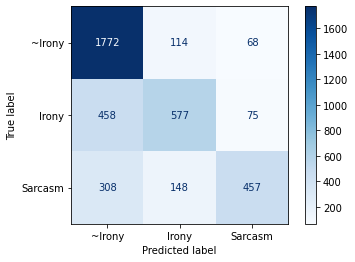

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.64      0.74      0.69       437
       Irony       0.39      0.42      0.40       219
     Sarcasm       0.42      0.25      0.32       216

    accuracy                           0.54       872
   macro avg       0.48      0.47      0.47       872
weighted avg       0.52      0.54      0.52       872



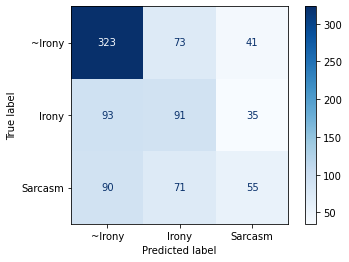

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_menthash.append({'SVM':d})

###Naive Bayes

####Multinomial

In [ ]:
param_grid={
    'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

In [ ]:
grid= GridSearchCV(MultinomialNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=MultinomialNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 0.0001}

In [ ]:
clf= MultinomialNB(alpha=0.0001)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.62      0.89      0.73      1954
       Irony       0.60      0.31      0.41      1110
     Sarcasm       0.62      0.41      0.49       913

    accuracy                           0.61      3977
   macro avg       0.61      0.53      0.54      3977
weighted avg       0.61      0.61      0.58      3977



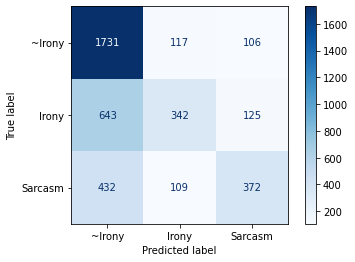

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.56      0.80      0.66       437
       Irony       0.40      0.18      0.25       219
     Sarcasm       0.36      0.25      0.29       216

    accuracy                           0.51       872
   macro avg       0.44      0.41      0.40       872
weighted avg       0.47      0.51      0.47       872



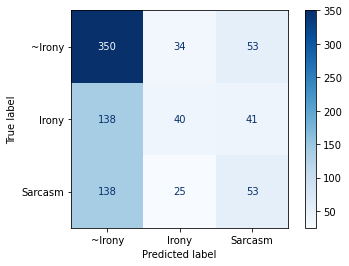

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_menthash.append({'Multinomial NB':d})

####Complement

In [ ]:
param_grid={
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'norm': [True, False]
}

In [ ]:
grid= GridSearchCV(ComplementNB(), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=ComplementNB(),
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'norm': [True, False]},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'alpha': 1, 'norm': False}

In [ ]:
clf= ComplementNB(alpha=1, norm=False)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.64      0.74      0.69      1954
       Irony       0.53      0.34      0.41      1110
     Sarcasm       0.49      0.54      0.51       913

    accuracy                           0.58      3977
   macro avg       0.56      0.54      0.54      3977
weighted avg       0.58      0.58      0.57      3977



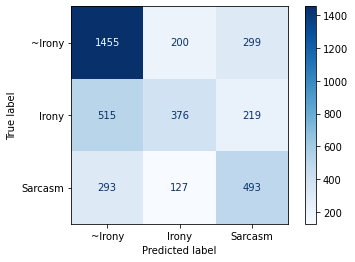

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.59      0.71      0.65       437
       Irony       0.43      0.18      0.25       219
     Sarcasm       0.36      0.42      0.39       216

    accuracy                           0.51       872
   macro avg       0.46      0.44      0.43       872
weighted avg       0.49      0.51      0.48       872



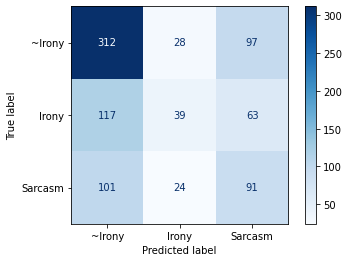

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_menthash.append({'Complement NB':d})

###DecisionTree

In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_tok, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 25,
 'min_samples_leaf': 20,
 'min_samples_split': 5}

In [ ]:
clf= DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_leaf=20, min_samples_split=5)
clf.fit(X_train_tok, y_train)

y_pred= clf.predict(X_train_tok)
y_pred_test= clf.predict(X_test_tok)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.68      0.84      0.75      1954
       Irony       0.53      0.48      0.51      1110
     Sarcasm       0.57      0.34      0.42       913

    accuracy                           0.63      3977
   macro avg       0.59      0.55      0.56      3977
weighted avg       0.61      0.63      0.61      3977



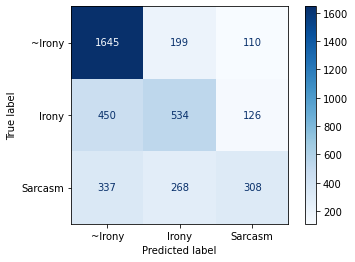

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.62      0.70      0.66       437
       Irony       0.34      0.43      0.38       219
     Sarcasm       0.43      0.21      0.28       216

    accuracy                           0.51       872
   macro avg       0.46      0.45      0.44       872
weighted avg       0.50      0.51      0.50       872



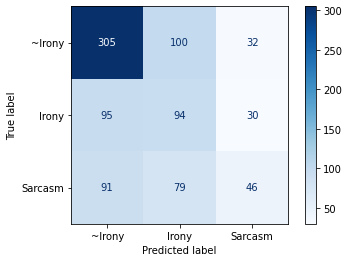

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
result= classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm'], output_dict=True)

In [ ]:
d=dict()
for key,value in result.items():
  if key not in ['accuracy','weighted avg']:
    d[key]= result[key]['f1-score']

In [ ]:
table_menthash.append({'DT':d})

#Recap table

In [ ]:
recap= pd.DataFrame()
for dic in table:
  recap= pd.concat([recap, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap

,~Irony,Irony,Sarcasm,macro avg
SVM,0.659341,0.367171,0.328841,0.451784
Multinomial NB,0.657870,0.259494,0.316076,0.411147
Complement NB,0.645702,0.248366,0.380165,0.424745
DT,0.646465,0.386179,0.310249,0.447631


In [ ]:
recap_lemm= pd.DataFrame()
for dic in table_lemm:
  recap_lemm= pd.concat([recap_lemm, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap_lemm

,~Irony,Irony,Sarcasm,macro avg
SVM,0.653153,0.412451,0.286550,0.450718
Multinomial NB,0.650143,0.257669,0.287263,0.398358
Complement NB,0.621762,0.203390,0.371901,0.399017
DT,0.654378,0.395722,0.222222,0.424107


In [ ]:
recap_menthash= pd.DataFrame()
for dic in table_menthash:
  recap_menthash= pd.concat([recap_menthash, pd.DataFrame.from_dict(dic, orient='index')])

In [ ]:
recap_menthash

,~Irony,Irony,Sarcasm,macro avg
SVM,0.685048,0.400881,0.317003,0.467644
Multinomial NB,0.658514,0.251572,0.292011,0.400699
Complement NB,0.645295,0.251613,0.389722,0.428876
DT,0.657328,0.382114,0.283951,0.441131
